# Problema de Negócio

Uma empresa de seguro, onde seus clientes utilizam seguro de saúde gostaria de saber se esses clientes comprariam um novo produto, um seguro de automóvel. Isso é importante para terem uma noção se esse novo produto seria viável ou não. Para sanar essa dúvida foi desenvolvida uma pesquisa que trouxe as informações sobre o cliente e quais consumidores comprariam e quais não comprariam o produto.

Existem novos clientes que não participaram da pesquisa e a empresa precisa saber se comprariam o seguro de alto-móvel ou não.

Para a venda do novo seguro foi criada uma campanha por telefone, e o limite de ligações será de 2000. O produto desenvolvido será um classificadorque crie um rank identificando os clientes mais propensos a adquirir o novo produto



# 0.0 Import Libraries and Load Data

In [1]:
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import inflection
import sklearn

from IPython.display       import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn import model_selection as ms
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

In [2]:
# Paleta de cores utilizada
custom_palette = ['#003366', '#006400', '#800020', '#3E2723']
sns.set_palette(custom_palette)
sns.color_palette(custom_palette)

[(0.0, 0.2, 0.4),
 (0.0, 0.39215686274509803, 0.0),
 (0.5019607843137255, 0.0, 0.12549019607843137),
 (0.24313725490196078, 0.15294117647058825, 0.13725490196078433)]

In [3]:
df_raw = pd.read_csv('data/train.csv')
# df_test = pd.read_csv('data/test.csv')

## 0.1 Separação de dados em Treino, Teste e Validação

In [4]:
df1 = df_raw.copy()

dfx = df1.drop(columns=['Response'])
dfy = df1['Response']

# Utilizei Estratificação para manter a mesma proporção entre as categorias durante o split
dfx_train, dfx_val, dfy_train, dfy_val =  ms.train_test_split(dfx, dfy, test_size = 0.3, stratify=dfy, random_state = 12)
dfx_val, dfx_test, dfy_val, dfy_test   =  ms.train_test_split(dfx_val, dfy_val, test_size = 0.5, stratify=dfy_val, random_state = 12)

df1 = pd.concat([dfx_train, dfy_train], axis=1)
print(dfy_train.value_counts())
print(dfy_val.value_counts())
print(dfy_test.value_counts())


Response
0    234079
1     32697
Name: count, dtype: int64
Response
0    50160
1     7006
Name: count, dtype: int64
Response
0    50160
1     7007
Name: count, dtype: int64


# 1.0 Data Description

## 1.1 Significado das colunas 

| Variable              | Definition                                                                                 |
|-----------------------|---------------------------------------------------------------------------------------------|
| `id`                 | Unique ID for the customer                                                                 |
| `Gender`             | Gender of the customer                                                                     |
| `Age`                | Age of the customer                                                                        |
| `Driving_License`    | 0: Customer does not have DL, 1: Customer already has DL                                    |
| `Region_Code`        | Unique code for the region of the customer                                                 |
| `Previously_Insured` | 1: Customer already has Vehicle Insurance, 0: Customer doesn't have Vehicle Insurance       |
| `Vehicle_Age`        | Age of the Vehicle                                                                         |
| `Vehicle_Damage`     | 1: Customer got his/her vehicle damaged in the past. 0: Customer didn't get his/her vehicle damaged in the past |
| `Annual_Premium`     | The amount customer needs to pay as premium in the year                                    |
| `Policy_Sales_Channel` | Anonymized Code for the channel of outreaching to the customer, e.g., Different Agents, Over Mail, Over Phone, In Person, etc. |
| `Vintage`            | Number of days the customer has been associated with the company                           |
| `Response`           | 1: Customer is interested, 0: Customer is not interested                                   |

## 1.2 Tipos de dados, tamanho do dataset e verificação de nulos 

In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 266776 entries, 142197 to 83271
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    266776 non-null  int64  
 1   Gender                266776 non-null  object 
 2   Age                   266776 non-null  int64  
 3   Driving_License       266776 non-null  int64  
 4   Region_Code           266776 non-null  float64
 5   Previously_Insured    266776 non-null  int64  
 6   Vehicle_Age           266776 non-null  object 
 7   Vehicle_Damage        266776 non-null  object 
 8   Annual_Premium        266776 non-null  float64
 9   Policy_Sales_Channel  266776 non-null  float64
 10  Vintage               266776 non-null  int64  
 11  Response              266776 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 26.5+ MB


Dataset não possui valores nulos, reduzindo trabalho de limpeza
  

In [6]:
print(f'Colunas: {df1.shape[1]}')
print(f'Linhas: {df1.shape[0]}')

Colunas: 12
Linhas: 266776


## 1.3 Renomeando colunas

In [7]:
cols = list(df1.columns)
lista = [inflection.underscore(coluna) for coluna in cols ]
df1.columns = lista
df1.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

## 1.4 Estatística descritiva

In [8]:
df1.head(3)

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
142197,142198,Male,24,1,28.0,1,< 1 Year,No,38109.0,152.0,261,0
43485,43486,Male,27,1,3.0,1,< 1 Year,No,38950.0,160.0,56,0
64479,64480,Male,34,1,30.0,0,1-2 Year,Yes,2630.0,124.0,13,1


In [9]:
# df_number = df1.select_dtypes(include = ['int64', 'float64'])
df_number = df1[['age', 'region_code','annual_premium',
                 'policy_sales_channel', 'vintage']].copy()

# df_object = df1.select_dtypes(include = ['object'])
df_object = df1[['gender', 'vehicle_age', 'vehicle_damage', 'driving_license',
                 'previously_insured', 'response']].copy()

### 1.4.1 Atributos numéricos

In [10]:
df_number.describe().T

,count,mean,std,min,25%,50%,75%,max
age,266776.0,38.813570,15.515349,20.0,25.00,36.0,49.00,85.0
region_code,266776.0,26.402019,13.238131,0.0,15.00,28.0,35.00,52.0
annual_premium,266776.0,30565.610898,17228.314487,2630.0,24395.75,31681.0,39406.25,540165.0
policy_sales_channel,266776.0,112.089247,54.184660,1.0,29.00,136.0,152.00,163.0
vintage,266776.0,154.210814,83.583484,10.0,82.00,154.0,227.00,299.0


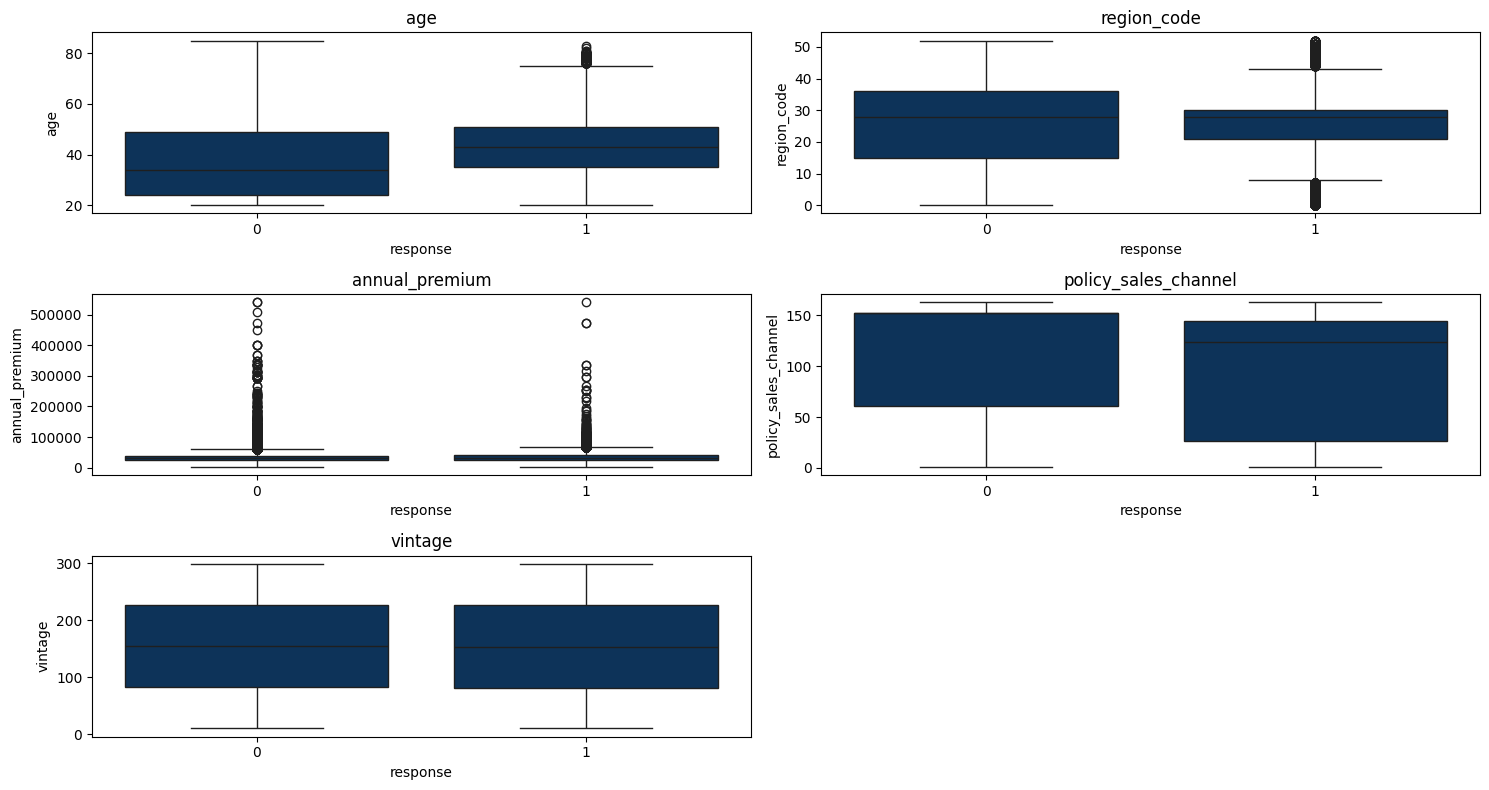

In [11]:
plt.figure(figsize=(15, 8))
for n, coluna in enumerate(df_number.columns, start=1):
    plt.subplot(3, 2, n)
    sns.boxplot(data=df1, x='response', y=coluna)
    plt.title(coluna)
    plt.tight_layout()


### 1.4.2 Atributos Categóricos 

In [12]:
df_object.apply(lambda x: x.unique())

gender                                 [Male, Female]
vehicle_age           [< 1 Year, 1-2 Year, > 2 Years]
vehicle_damage                              [No, Yes]
driving_license                                [1, 0]
previously_insured                             [1, 0]
response                                       [0, 1]
dtype: object

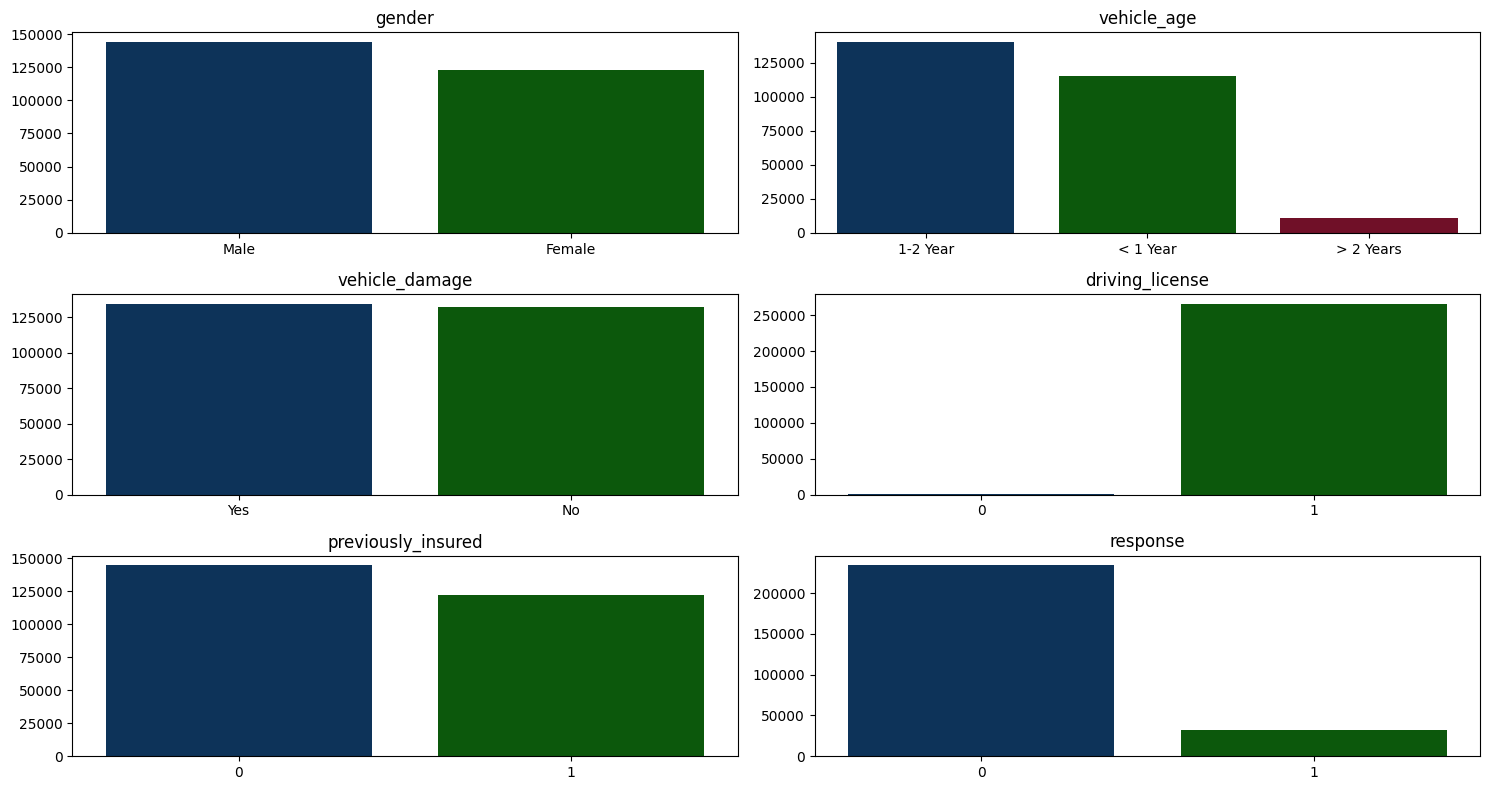

In [13]:
plt.figure(figsize=(15, 8))

for n, coluna in enumerate(df_object.columns, start=1):
    counts = df_object[coluna].value_counts()
    plt.subplot(3, 2, n) 
    sns.barplot( x=counts.index, y=counts.values, hue = counts.index)
    plt.xlabel('')
    plt.title(coluna)
    plt.legend([], frameon=False)
    plt.tight_layout()
    

#  2.0 Feature Engeneering

## 2.0.1 Negócio

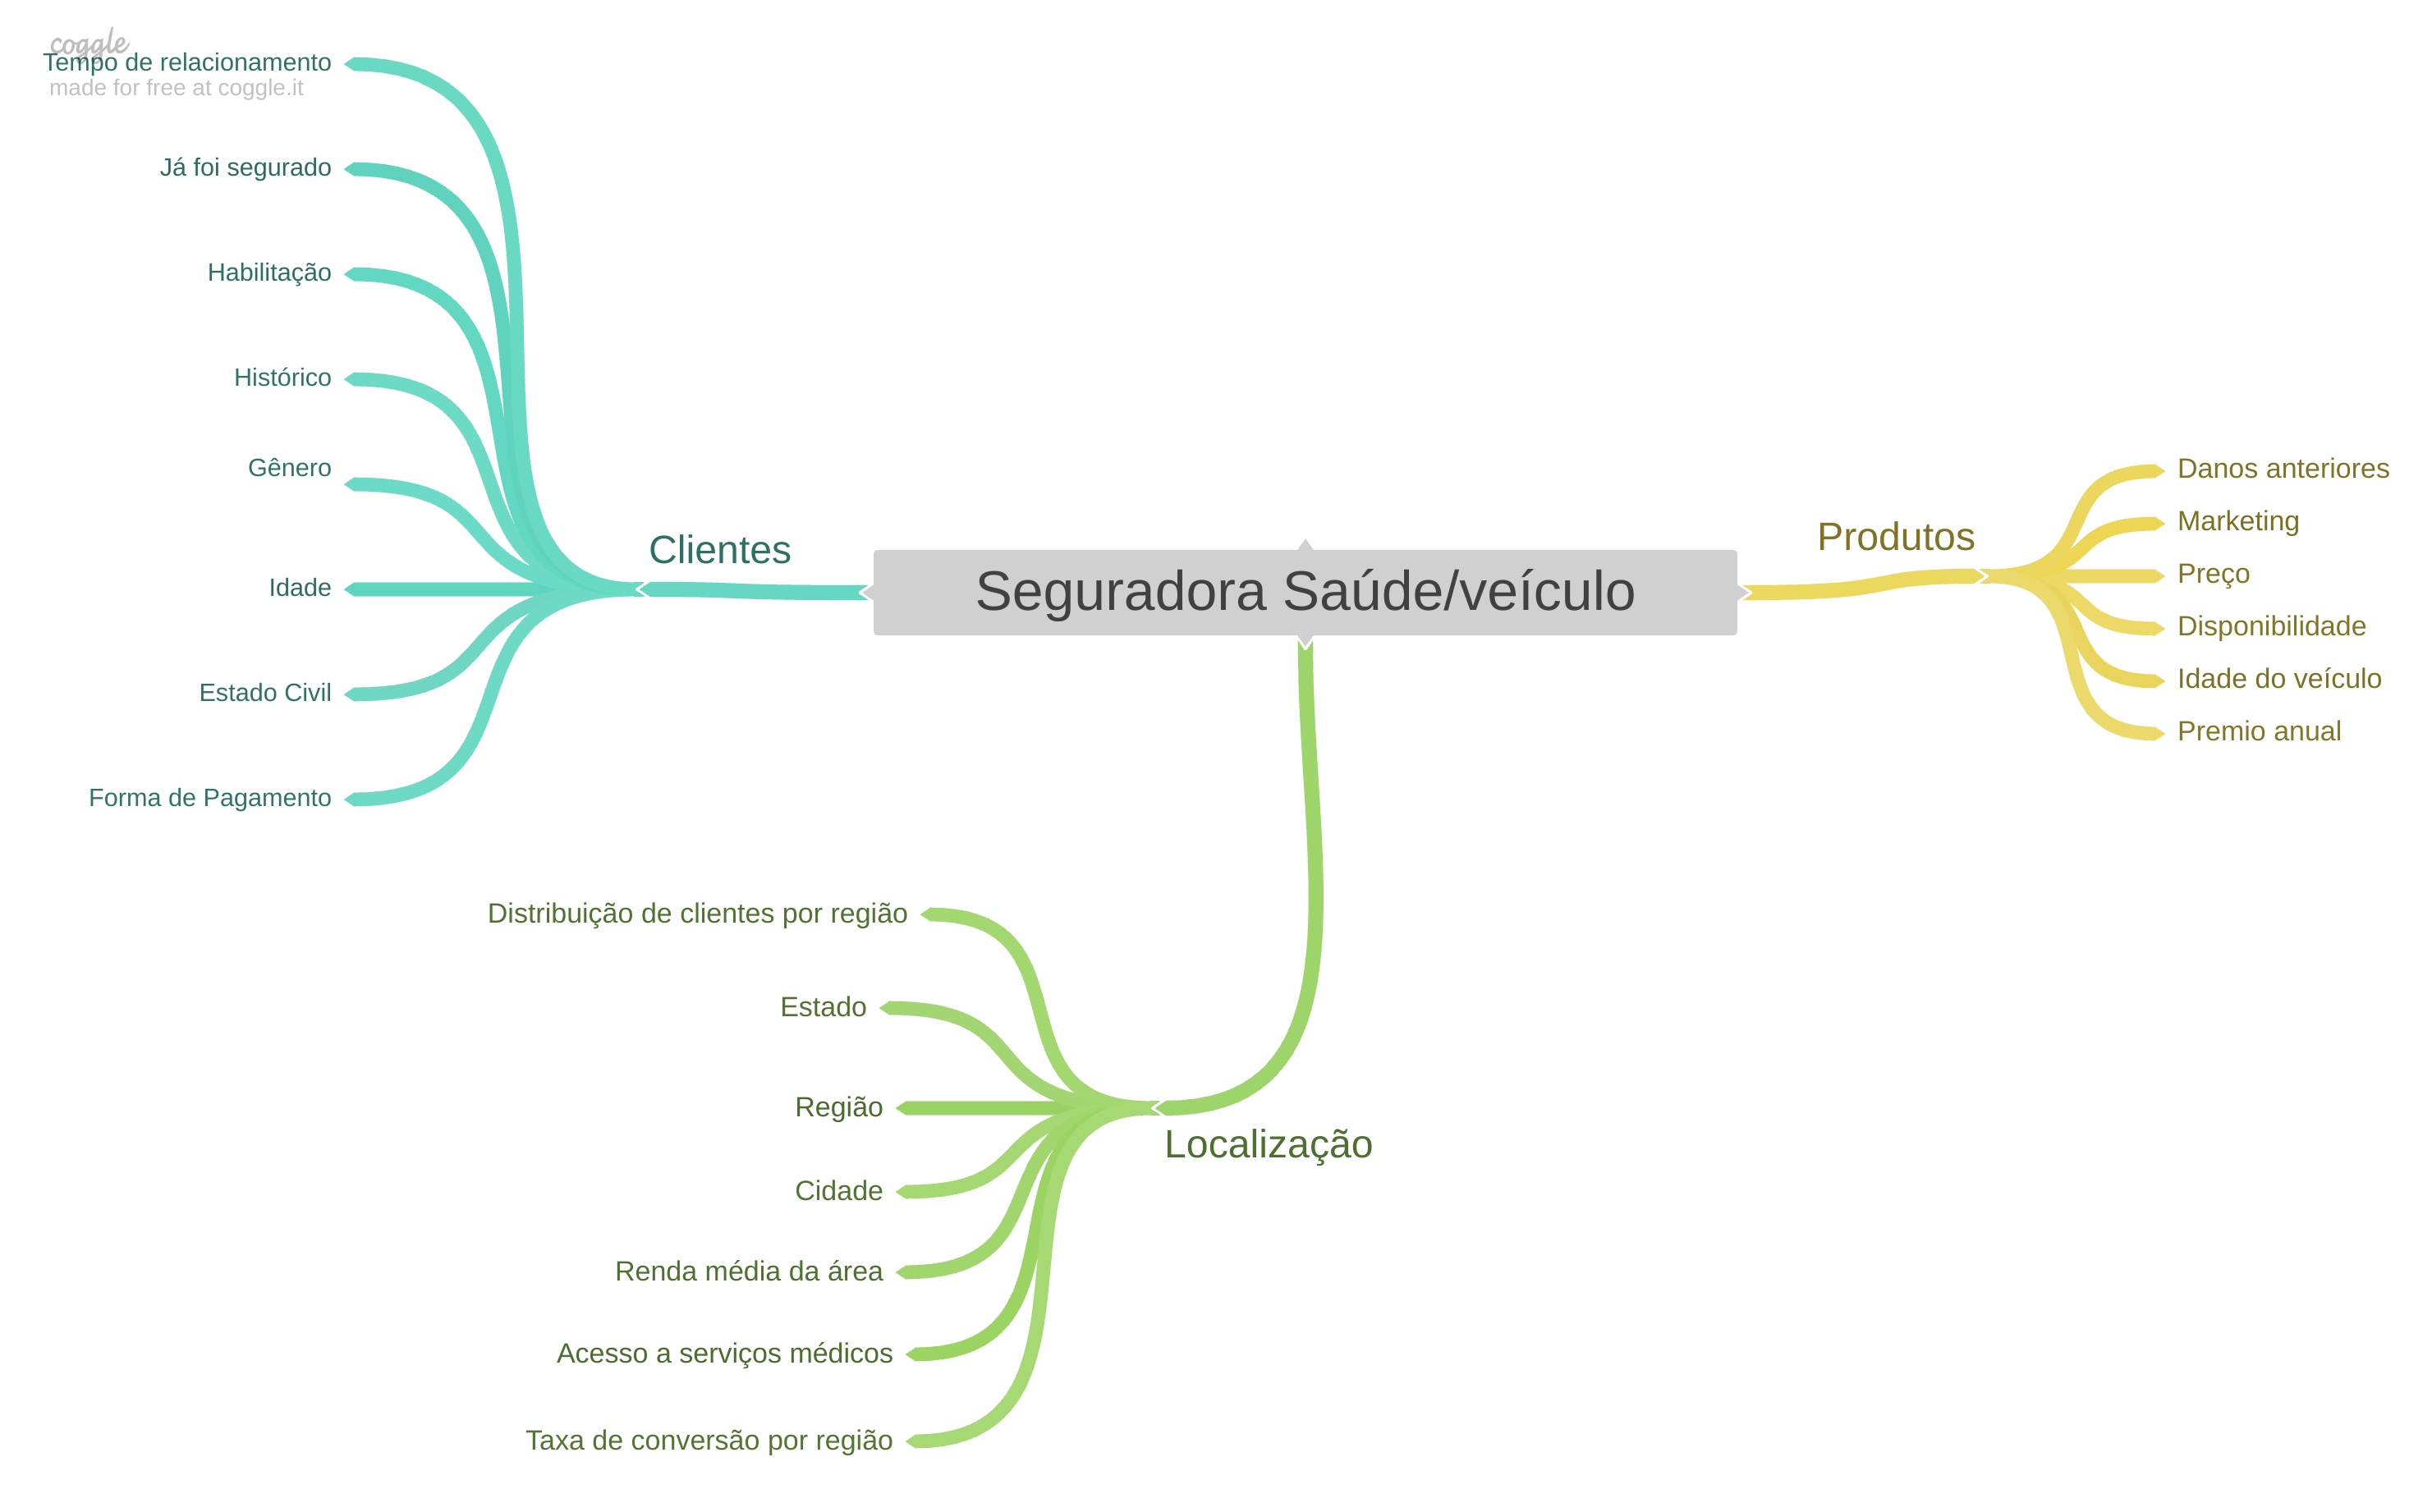

In [14]:
Image('img/img_seguradora.png')

## 2.1 Criação das Hipóteses

### 2.1.1 Hipóteses para Clientes

1. Clientes mais experientes (>=30 anos) têm maior propensão a contratar seguros para veículos pelo desejo de segurança.  

2. Clientes que já tiveram seguro anteriormente tem maior interesse em contratar o seguro.
3. Mulheres tem uma propenção maior para contratar seguros.
4. Clientes casados ou com filhos tendem a contratar seguros mais robustos devido à necessidade de proteção familiar.
5. Clientes com habilitação recente apresentam maior risco e, consequentemente, optam por planos básicos devido ao custo.


### 2.1.2 Hipóteses para Produtos

1. Clientes com veículos entre 1 e 2 anos são mais comumentes interessados no seguro.

2. Planos com preços acessíveis e benefícios extras, como assistência 24 horas, têm maior taxa de conversão.
3. Pessoas que já sofreram danos em veículos tem maior interesse em contratar o seguro.
4. A inclusão de seguros específicos para veículos elétricos ou híbridos pode atrair clientes com maior poder aquisitivo.
5. Pessoas que já tiveram seguro anteriormente tem maior interesse em contratar o seguro.


### 2.1.3 Hipóteses para Localização

1. Regiões com maior índice de roubos e furtos têm maior demanda por seguros com cobertura contra roubo.

2. Clientes em áreas urbanas têm maior adesão a seguros devido à maior exposição a acidentes.
3. Regiões com renda média mais alta têm maior interesse em seguros premium, com coberturas completas.
4. Cidades com menor acesso a serviços médicos ou oficinas têm maior interesse em seguros com benefícios de assistência em viagens.
5. Áreas com alto índice de acidentes de trânsito têm maior conversão em seguros com coberturas de danos a terceiros.

## 2.2 Top 10 Hipóteses  

1. Clientes mais experientes (>=30 anos) têm maior propensão a contratar seguros para veículos por procurar segurança.  

2. Clientes que já possuem um histórico de seguro têm maior probabilidade de se interessar pelo seguro. 

3. Mulheres tem maior propenção para contratar seguros, priorizando segurança.  

4. Clientes que já sofreram danos em veículos no passado têm maior chance de contratar seguros. 

5. Planos com preços mais acessíveis atraem clientes jovens ou com menor histórico de seguro. 

6. Clientes com mais ano de casa tem maior propenção de desejar o novo produto . 

7. Clientes com veículos mais novos são mais comumentes interessados no seguro. 

8. Clientes em regiões onde há maior proporção de veículos danificados têm maior probabilidade de contratar seguros.

9. Taxas mais altas de prêmios anuais são mais frequentes para jovens com veículos antigos.

10. Clientes que possuem habilitação e têm veículos mais antigos contratam seguros mais básicos devido ao custo-benefício.



1. **Clientes mais jovens (18-30 anos) têm maior propensão a contratar seguros para veículos mais antigos devido à menor capacidade de adquirir carros novos.**  
   - **Dados necessários:** `age`, `vehicle_age`.  

2. **Clientes que já possuem um histórico de seguro têm maior probabilidade de renovação ou upgrade de plano.**  
   - **Dados necessários:** `previously_insured`, `response`.  

3. **Mulheres têm maior propensão a contratar seguros com coberturas mais completas, priorizando segurança.**  
   - **Dados necessários:** `gender`, `response`.  

4. **Clientes que já sofreram danos em veículos no passado têm maior chance de contratar seguros.**  
   - **Dados necessários:** `vehicle_damage`, `response`.  

5. **Planos com preços mais acessíveis atraem clientes jovens ou com menor histórico de seguro.**  
   - **Dados necessários:** `annual_premium`, `age`, `previously_insured`.  

6. **Regiões com menor taxa de seguros contratados têm maior potencial para campanhas de marketing direcionadas.**  
   - **Dados necessários:** `region_code`, `response`.  

7. **Veículos mais novos (0-3 anos) têm maior adesão a seguros devido ao alto valor de mercado e menor risco de manutenção.**  
   - **Dados necessários:** `vehicle_age`, `response`.  

8. **Clientes em regiões onde há maior proporção de veículos danificados têm maior probabilidade de contratar seguros.**  
   - **Dados necessários:** `region_code`, `vehicle_damage`.  

9. **Taxas mais altas de prêmios anuais são mais frequentes em regiões urbanas do que em regiões rurais.**  
   - **Dados necessários:** `region_code`, `annual_premium`.  

10. **Clientes que possuem habilitação e têm veículos mais antigos contratam seguros mais básicos devido ao custo-benefício.**  
    - **Dados necessários:** `driving_license`, `vehicle_age`, `response`.  


## 2.3 Feature Engeneering

In [15]:
df2 = df1.copy()
df2.head(2)

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
142197,142198,Male,24,1,28.0,1,< 1 Year,No,38109.0,152.0,261,0
43485,43486,Male,27,1,3.0,1,< 1 Year,No,38950.0,160.0,56,0


In [39]:
df2 = df1.copy()

# Separando clientes por custo do prêmio (categoria)
df2['premium_category'] = pd.cut(df2['annual_premium'],
                                 bins=[0, 10000, 30000, 50000, np.inf],
                                 labels=['Baixo\n(0:10000)', 'Médio\n(10000:30000)', 'Alto\n(30000:50000)', 'Muito Alto\n(50000:)'])

# # Separando clientes por custo do prêmio (valor)
# df2['premium_category_number'] = pd.cut(df2['annual_premium'],
#                                  bins=[0, 10000, 30000, 50000, np.inf],
#                                  labels=['(0:10000]', '(10000:30000]', '(30000:50000]', '(50000:)'])

# Separando grupos de clientes de acordo com o tempo de 'vintage' (dias)
df2['vintage_group'] = pd.cut(df2['vintage'], bins=[0, 60, 120, 240, np.inf], labels=['Recente\n(0:60)dias', 'Intermediário\n(60:120)', 'Longo\n(120:240)', 'Muito Longo\n(240:)'])

# 3 - EDA (Análise Exploratória de Dados)

## 3.1 Análise Univariada

### 3.1.1 Variavel Responsta

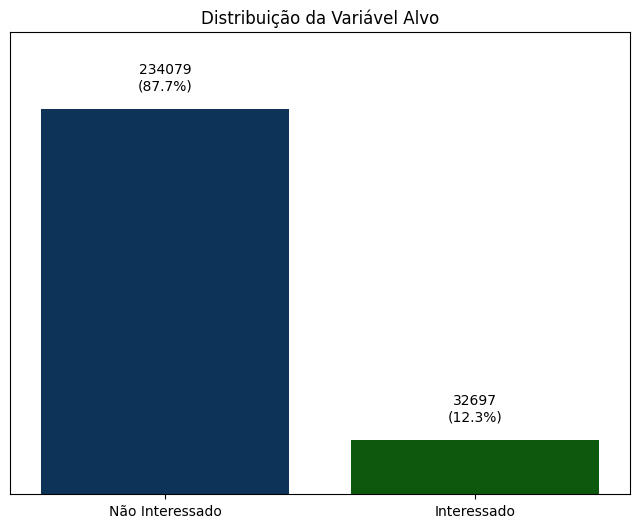

In [17]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df1, x='response', hue='response', dodge=False)

ax.legend([], [], frameon=False)
ax.yaxis.set_visible(False)

plt.xticks(ticks=[0, 1], labels=['Não Interessado', 'Interessado'])
plt.xlabel('')
plt.title('Distribuição da Variável Alvo')

plt.ylim(0, df1['response'].value_counts().max() * 1.2)

total = len(df1)
category_counts = df1['response'].value_counts()

for index, category in enumerate(category_counts.index):
    count = category_counts[category] 
    percentage = 100 * count / total 
    x = index 
    y = count +10000
    ax.text(x, y, f'{count}\n({percentage:.1f}%)', ha='center', va='bottom', fontsize=10)

plt.show()


- Como há um desbalanceamento de classes e o objetívo é encontrar os clientes com a maior propensão de compra utilizarei a métrica Precision para identificar os acertos na classe de interesse.

### 3.1.2 Distribuições das Variáveis Numéricas

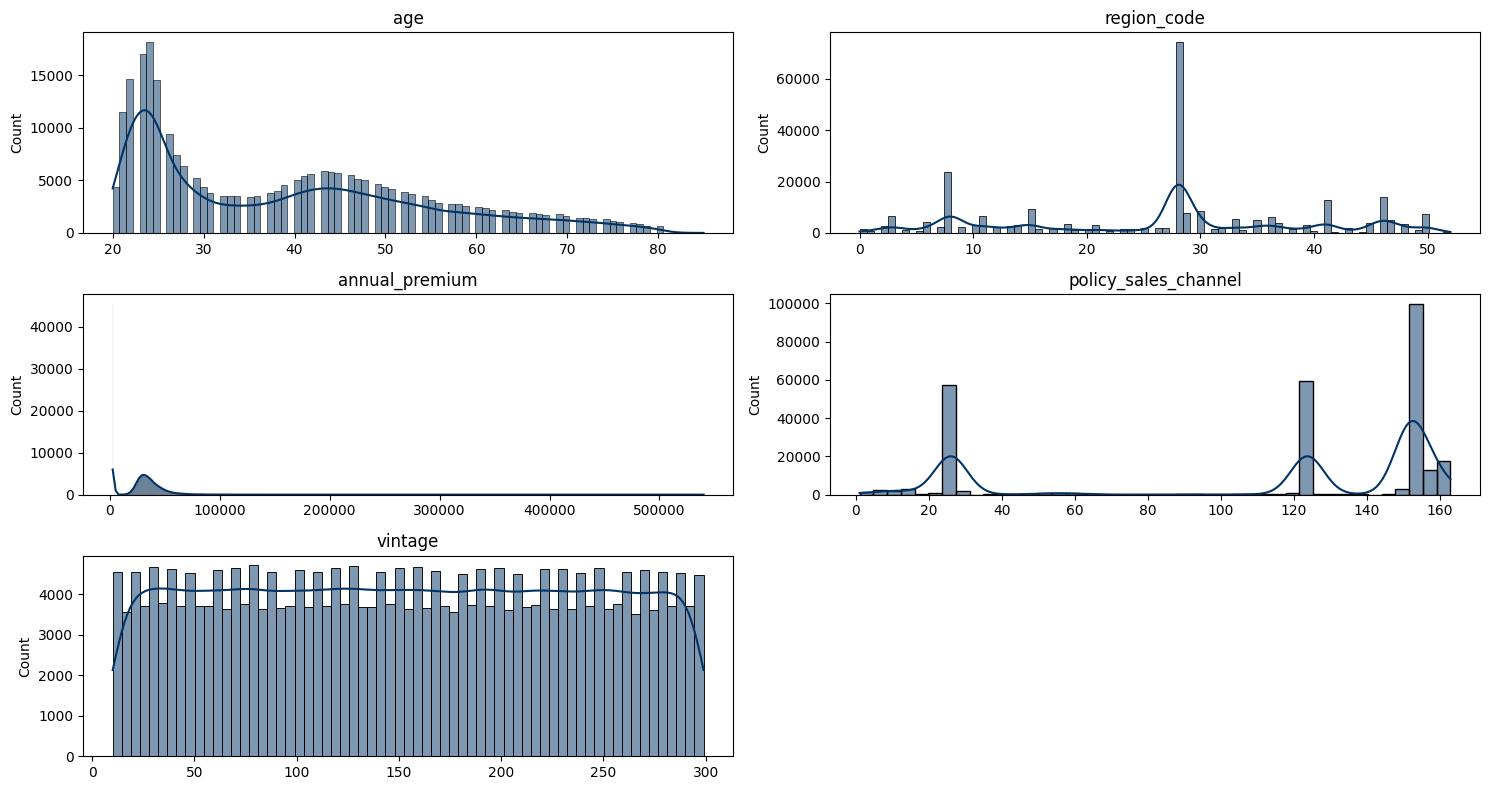

In [18]:
plt.figure(figsize=(15, 8))
for n, coluna in enumerate(df_number.columns, start=1):
    plt.subplot(3, 2, n)  
    sns.histplot(data=df_number, x=coluna, kde=True)
    plt.title(coluna)
    plt.xlabel('')
    plt.tight_layout()


- A distribuição de 'age' está mais concentrada em jovens de 20 a 25 anos, é uma ótima oportunidade de gerar uma relação duradoura e lucrativa com o cliente.
- As demais variaveis necessitam de uma análise mais aprofundada  

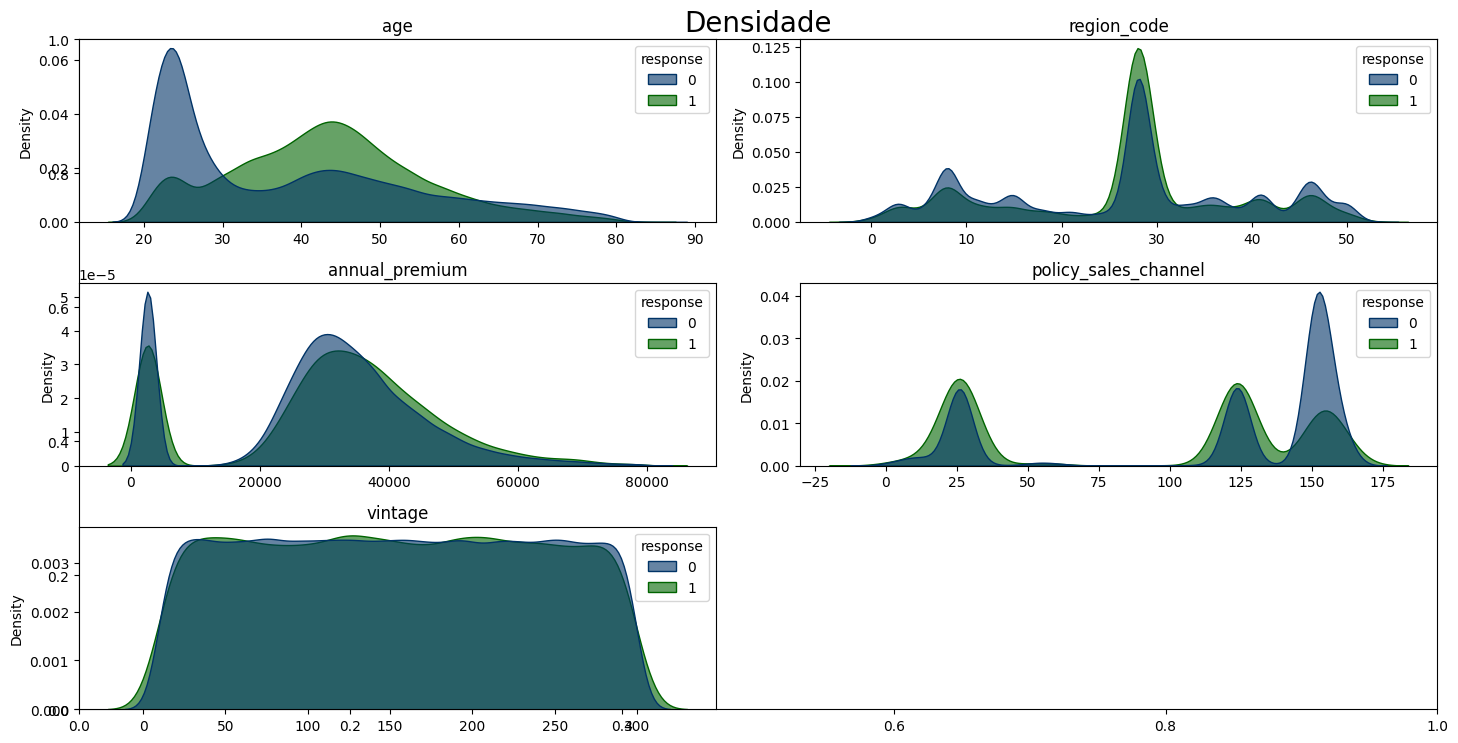

In [19]:
df_combined = df_number.copy()
df_combined['response'] = df1['response']
df_combined = df_combined.loc[df_combined['annual_premium']<80000,:]

plt.figure(figsize=(15, 8))
plt.title('Densidade',size = 20)
for n, coluna in enumerate(df_number.columns, start=1):
    plt.subplot(3, 2, n)  
    sns.kdeplot(data=df_combined, x=coluna, hue='response', fill=True, common_norm=False, alpha=0.6)
    plt.title(coluna)
    plt.xlabel('')
    plt.tight_layout()

- Novamente 'age' chama atenção, porém demonstrando que clientes mais jovens tem um menor interesse em seguro de veículos. Essa informação será de grande valor para o modelo.
- Outras variaveis tambem demonstram um certo comportamento mas bem menos perceptivo.

### 3.1.3 Distribuição das Variáveis categóricas

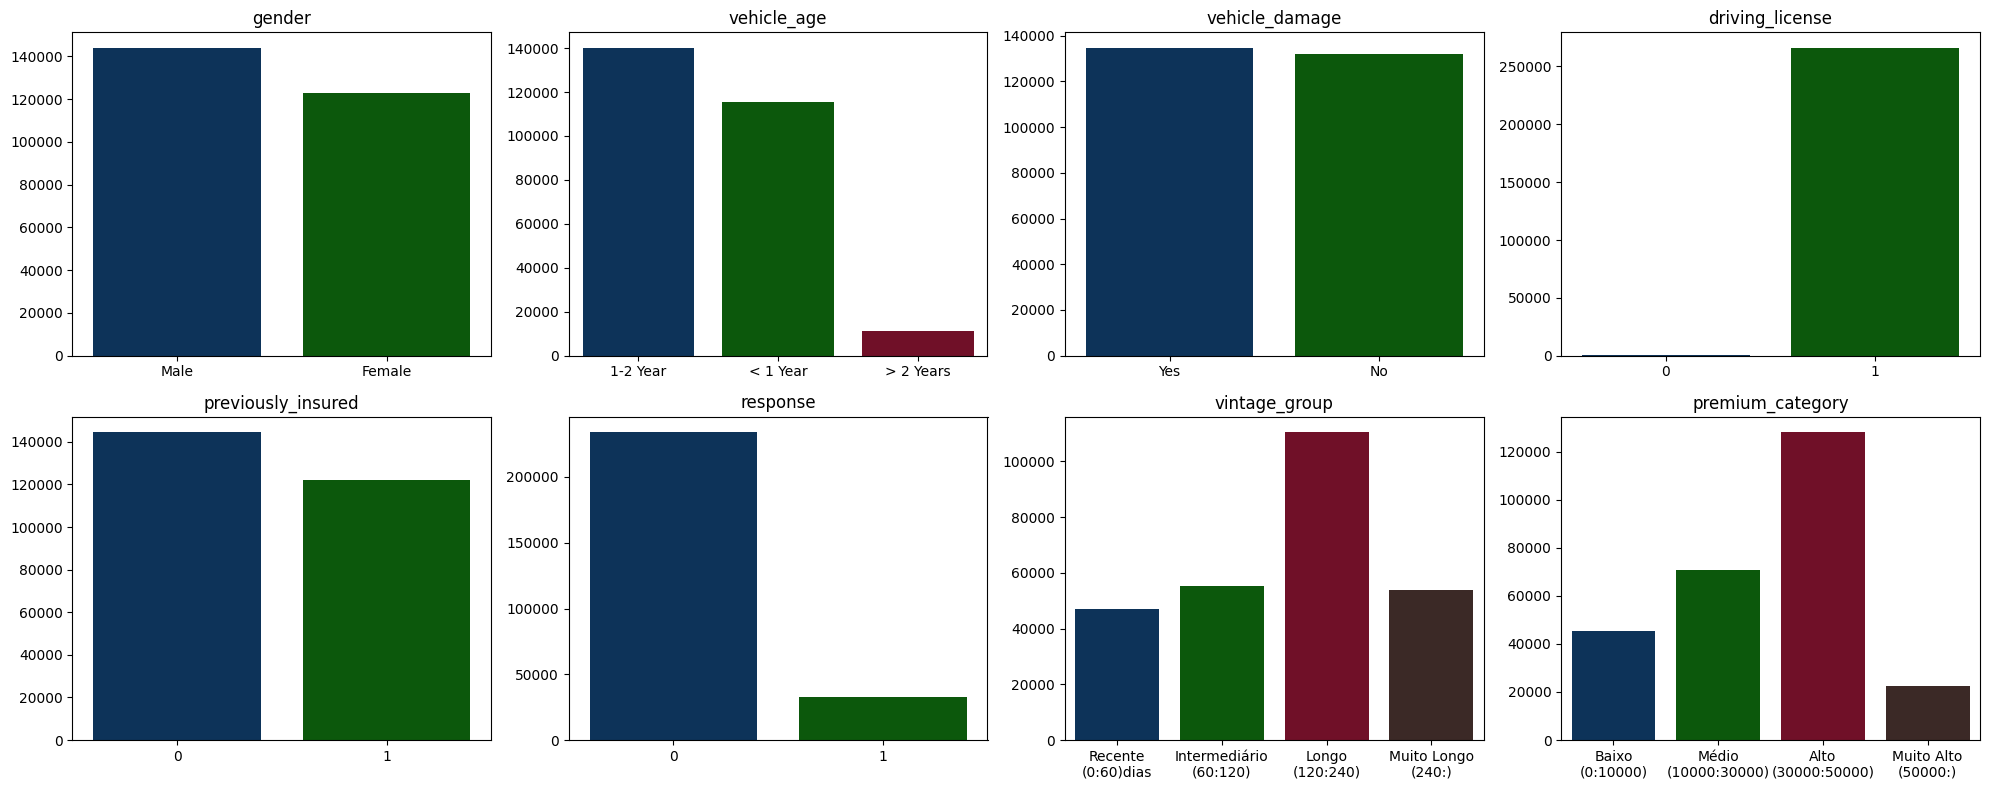

In [40]:
plt.figure(figsize=(20, 8))
df_object['vintage_group'] = df2['vintage_group']
df_object['premium_category'] = df2['premium_category']

for n, coluna in enumerate(df_object.columns, start=1):
    counts = df_object[coluna].value_counts()
    plt.subplot(2, 4, n) 
    sns.barplot( x=counts.index, y=counts.values, hue = counts.index)
    plt.xlabel('')
    plt.title(coluna)
    plt.legend([], frameon=False)
    plt.tight_layout()
    
    

# 3.2 Analise Bivariada

### 3.2.1 Distribuição de variaveis por categoria e por interesse no produto

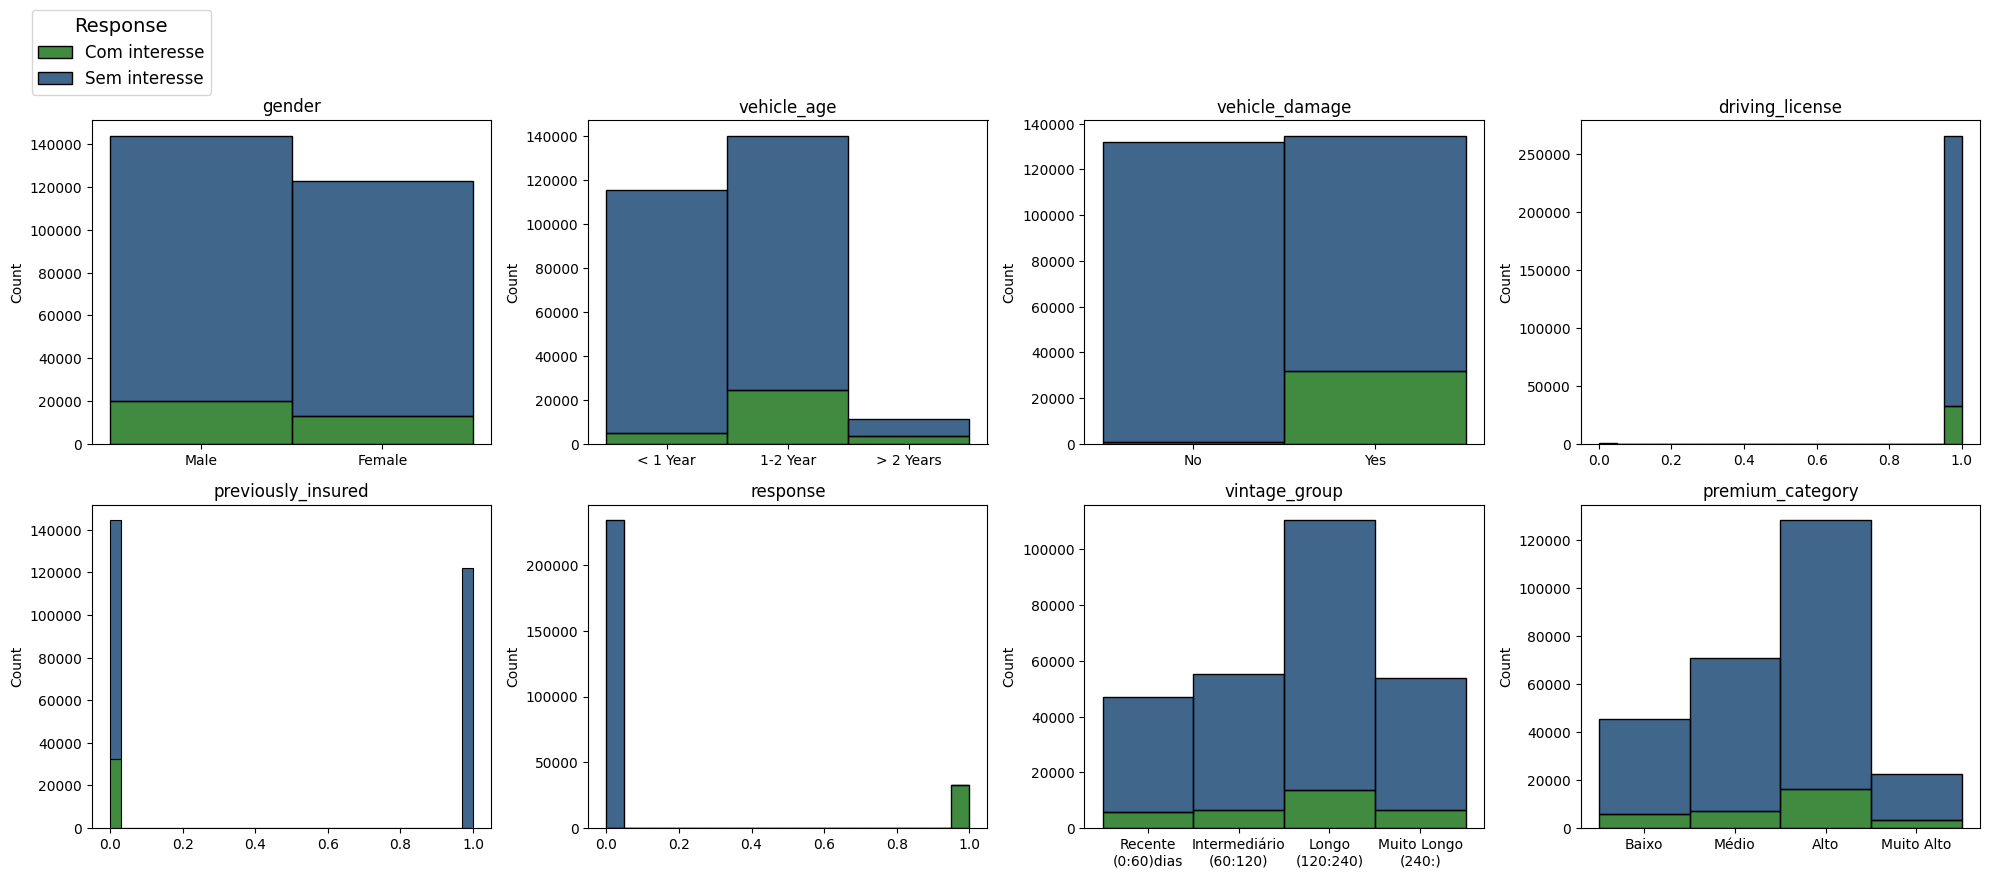

In [21]:
plt.figure(figsize=(20, 8))
for n, coluna in enumerate(df_object.columns, start=1): 
    plt.subplot(2, 4, n)
    sns.histplot(data=df_object, x=coluna, hue="response", multiple="stack")
    plt.title(coluna)
    plt.xlabel('')
    plt.legend([], frameon=False)
    plt.tight_layout()

plt.legend(
        title="Response",
        title_fontsize=14, fontsize=12, 
        labels=['Com interesse','Sem interesse'],
        loc="center left",
        bbox_to_anchor=(-3.9, 2.4))

plt.show()

- Clientes com veículos entre 1 e 2 anos são mais comumentes interessados no seguro.
- Pessoas que já sofreram danos em veículos tem maior interesse em contratar o seguro.
- Não existem ou existem muito poucas pessoas sem carteira de motorista na base de dados.
- Pessoas que já tiveram seguro anteriormente tem maior interesse em contratar o seguro.

In [22]:
df_object['driving_license'].value_counts()

driving_license
1    266215
0       561
Name: count, dtype: int64

### 3.2.2 Validação de Hipóteses

#### H1. Clientes mais experientes (>=30 anos) têm maior propensão a contratar seguros para veículos por procurar segurança.  

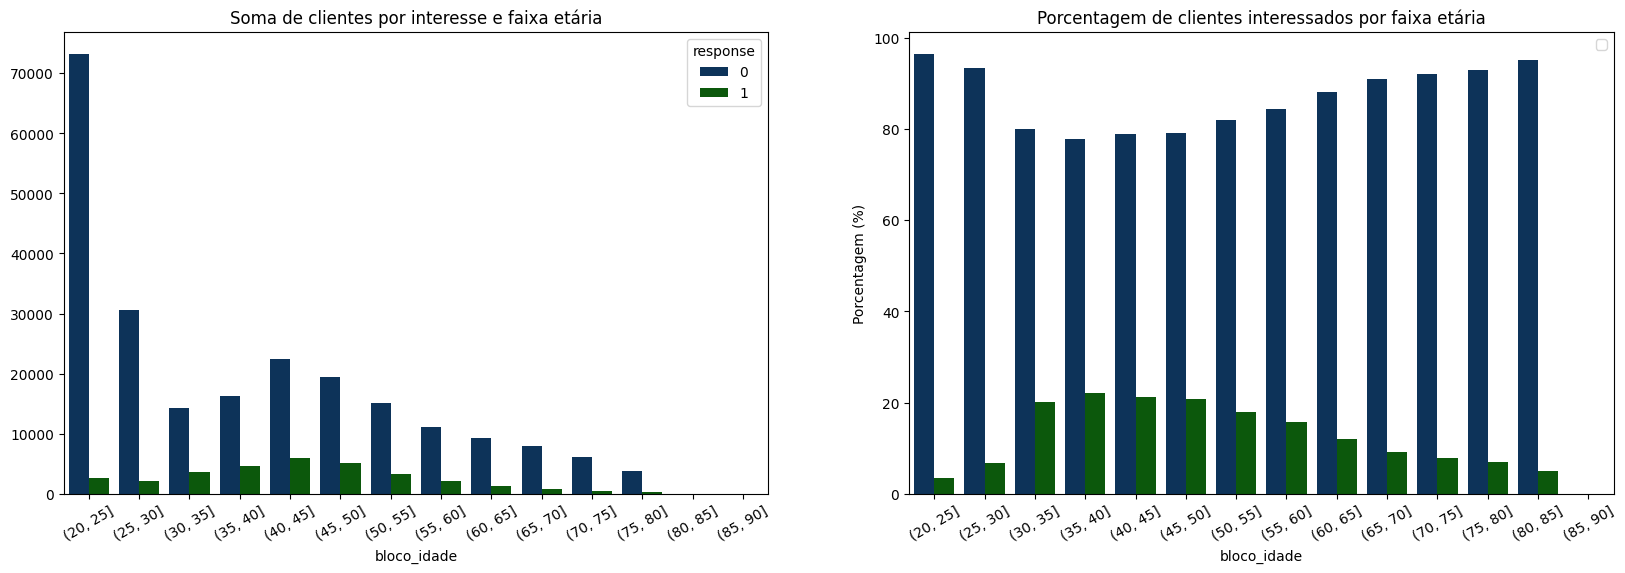

In [185]:
aux1 = df2.copy()
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
bins = list(range(20,91,5))
aux1['bloco_idade'] = pd.cut(aux1['age'],bins=bins)
aux2 = aux1.loc[:,['id','bloco_idade', 'response']].groupby(['bloco_idade','response'],observed=False).count().reset_index()
sns.barplot(data = aux2, x='bloco_idade', y= "id",hue='response')
plt.ylabel('')
plt.xticks(rotation = 30);
plt.title('Soma de clientes por interesse e faixa etária');

plt.subplot(1,2,2)
plt.title('Porcentagem de clientes interessados por faixa etária')
bins = list(range(20,91,5))
aux1['bloco_idade'] = pd.cut(aux1['age'],bins=bins)
aux3 = aux1.loc[:,['id','bloco_idade', 'response']].groupby(['bloco_idade','response'],observed=False).count().reset_index()
total_por_faixa = aux3.groupby('bloco_idade',observed=False)['id'].sum()
total_por_faixa_categoria = aux3.groupby(['bloco_idade', 'response'],observed=False)['id'].sum()
porcentagem_categoria = (total_por_faixa_categoria / total_por_faixa) * 100
aux3 = pd.DataFrame(porcentagem_categoria)
sns.barplot(data = aux3, x='bloco_idade', y= "id",hue='response')
plt.legend([])
plt.xticks(rotation = 30);
plt.ylabel('Porcentagem (%)');

#### H2. Clientes que já possuem um histórico de seguro têm maior probabilidade de se interessar pelo seguro. 

#### H3. Mulheres tem maior propenção para contratar seguros, priorizando segurança. 

#### H4. Clientes que já sofreram danos em veículos no passado têm maior chance de contratar seguros. 

#### H5. Planos com preços mais acessíveis atraem clientes jovens ou com menor histórico de seguro. 

#### H6. Clientes com mais ano de casa tem maior propenção de desejar o novo produto . 

#### H7. Clientes com veículos mais novos são mais comumentes interessados no seguro. 

#### H8. Clientes em regiões onde há maior proporção de veículos danificados têm maior probabilidade de contratar seguros.

#### H9. Taxas mais altas de prêmios anuais são mais frequentes para jovens com veículos antigos.

#### H10. Clientes que possuem habilitação e têm veículos mais antigos contratam seguros mais básicos devido ao custo-benefício.

# 5.0 Model Training 

In [24]:
df_number.head(2)

,age,region_code,annual_premium,policy_sales_channel,vintage
142197,24,28.0,38109.0,152.0,261
43485,27,3.0,38950.0,160.0,56


## 2.1 Normalização dos dados 

In [25]:
x_train = df_number.copy()
scaler = MinMaxScaler(feature_range=(0, 1)) 

cols_n = ['age','region_code', 'annual_premium','policy_sales_channel','vintage']
x_train[cols_n] = scaler.fit_transform(x_train[cols_n])

cols = list(dfx_val.columns)
lista = [inflection.underscore(coluna) for coluna in cols ]
dfx_val.columns = lista

x_val = dfx_val[cols_n].copy()
x_val[cols_n] = scaler.fit_transform(x_val[cols_n])

y_train = df1['response']
y_val = dfy_val

## 2.2 Modelagem 

In [26]:
# define 
model = LogisticRegression(max_iter=200)

# training
model.fit(x_train, y_train)

# performance
yhat_val = model.predict(x_val)

## 2.3 Performance

In [27]:
f1 = mt.f1_score(y_val, yhat_val)
print(f'F1 Score = {f1}')

precision = mt.precision_score(y_val, yhat_val)
print(f"Precision: {precision}")

F1 Score = 0.0
Precision: 0.0


/home/rafaelluckner/.pyenv/versions/3.12.7/envs/propencao_compra/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


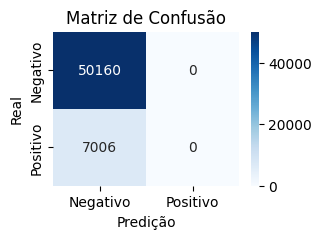

In [28]:
cm = mt.confusion_matrix(y_val, yhat_val)
plt.figure(figsize=(3, 2))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.xlabel('Predição')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

## Roc Curve

AUC: 0.6500713901640928


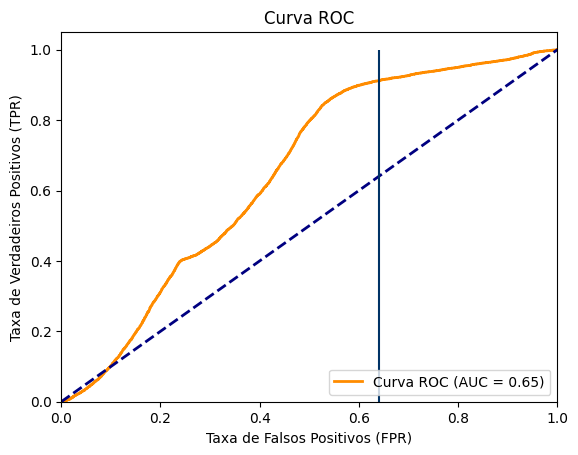

In [29]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


yhat_val = model.predict_proba(x_val)
yhat_val = yhat_val[:,1]
# Calculando os pontos da curva ROC
fpr, tpr, thresholds = roc_curve(y_val, yhat_val)
roc_auc = auc(fpr, tpr)

# Plotando a curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.vlines(0.64, 0, 1)
print(f"AUC: {roc_auc}")


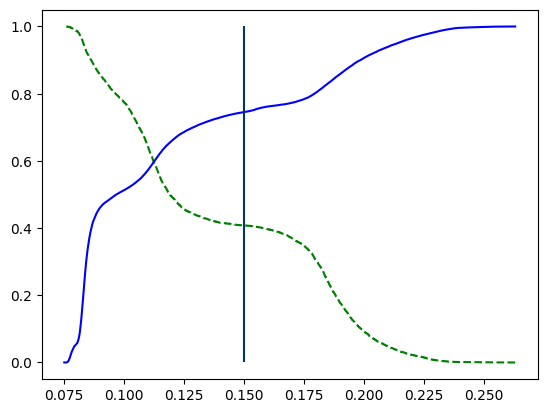

In [30]:
plt.plot(thresholds, tpr, 'g--', label = 'TPR')
plt.plot(thresholds, 1-fpr, 'b-', label = 'TPR')
plt.vlines(0.15, 0, 1)

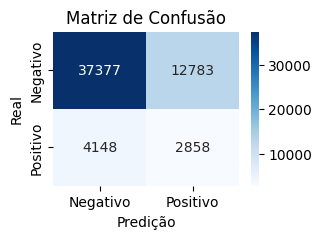

In [31]:
th = 0.15
y_pred = [1 if i > th else 0 for i in yhat_val]
y_pred[0:10]
cm = mt.confusion_matrix(y_val, y_pred)
plt.figure(figsize=(3, 2))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.xlabel('Predição')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

In [32]:
f1 = mt.f1_score(y_val, y_pred)
print(f'F1 Score = {f1}')

precision = mt.precision_score(y_val, y_pred)
print(f"Precision: {precision}")

F1 Score = 0.2523954607674306
Precision: 0.18272488971293396


F1 Score = 0.3217618514371034

Precision: 0.26777862741349645

F1 Score = 0.10899625833740036

Precision: 0.12627214474180173

## proba

In [33]:
x_val

,age,region_code,annual_premium,policy_sales_channel,vintage
339818,0.876923,0.538462,0.078164,0.154321,0.183391
77515,0.353846,0.538462,0.118176,0.154321,0.920415
190152,0.015385,0.576923,0.060454,0.932099,0.259516
229493,0.600000,0.576923,0.000000,0.944444,0.162630
380677,0.061538,0.711538,0.060888,0.932099,0.633218
...,...,...,...,...,...
108438,0.046154,0.288462,0.095184,0.932099,0.290657
352057,0.076923,0.788462,0.095753,0.932099,0.491349
257433,0.753846,0.269231,0.139205,0.154321,0.339100
100510,0.676923,0.788462,0.062549,0.746914,0.785467


In [34]:
df_proba = x_val.copy()
df_proba['proba'] = yhat_val
df_proba['response'] = y_val

df_proba.sort_values(by= 'proba',ascending = False).head(20)

,age,region_code,annual_premium,policy_sales_channel,vintage,proba,response
276821,0.953846,0.961538,0.087575,0.043210,0.363322,0.262871,0
320701,0.907692,0.538462,0.106619,0.012346,0.044983,0.262262,0
2873,0.923077,0.000000,0.000000,0.012346,0.439446,0.260590,0
60887,0.923077,0.961538,0.144781,0.043210,0.089965,0.260154,0
105948,0.923077,0.961538,0.133289,0.043210,0.498270,0.258723,0
252386,0.923077,0.961538,0.000000,0.043210,0.903114,0.257513,0
50190,0.923077,0.153846,0.165060,0.037037,0.460208,0.256552,0
328063,0.923077,0.884615,0.124617,0.061728,0.124567,0.256508,0
18761,0.876923,0.134615,0.000000,0.012346,0.269896,0.256394,0
136155,0.907692,0.961538,0.100777,0.043210,0.678201,0.256361,0
